# Dog Breed Classification using AWS Sagemaker

This notebook walks through implementation of  Image Classification Machine Learning Model to classify between 133 kinds of dog breeds using dog breed dataset provided by Udacity (https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)

* We will be using a pretrained Resnet50  model from pytorch vision library (https://pytorch.org/vision/master/generated/torchvision.models.resnet50.html)
* We will be adding in two Fully connected Neural network Layers on top of the above Resnet50 model.
* Note: We will be using concepts of Transfer learning and so we will be freezing all the exisiting Convolutional layers in the pretrained resnet50 model and only changing gradients for the tow fully connected layers that we have added.
* Then we will perform Hyperparameter tuning, to help figure out the best hyperparameters to be used for our model.
* Next we will be using the best hyperparameters and fine-tuning our Resent50 model.
* We will also be adding in configuration for Profiling and Debugging our training mode by adding in relevant hooks in the Training and Testing( Evaluation) phases.
* Next we will be deploying our model. While deploying we will create our custom inference script. The custom inference script will be overriding a few functions that will be used by our deployed endpoint for making inferences/predictions.
* Finally we will be testing out our model with some test images of dogs, to verfiy if the model is working as per our expectations.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-874422048278


## Dataset

We will be using the Dog breed dataset that is provided by Udacity.<br>
The dataset contains images of dogs belonging to a total of 133 different breeds from around the world. 
We will be using these dog images to train our image classification model to classify between the  different dog breeds.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#Setting the output to dev/null as the output contains 7K+ unnecessary output lines
!unzip dogImages.zip  > /dev/null

--2021-12-11 18:51:41--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.24
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.2MB/s    in 24s     

2021-12-11 18:52:16 (45.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [10]:
prefix ="dogImagesDataset"
print("Starting to uploading dogImages")

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")


Starting to uploading dogImages
Input path ( S3 file path ): s3://sagemaker-us-east-1-874422048278/dogImagesDataset


In [5]:
#adding here only for rerun purposes ( to avoid uploading the inputs again)
inputs = 's3://sagemaker-us-east-1-874422048278/dogImagesDataset'
print(f"Input path ( S3 file path ): {inputs}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-874422048278/dogImagesDataset


## Hyperparameter Tuning

* The ResNet50 model with a two Fully connected Linear NN layer's is used for this image classification problem. ResNet-50 is 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database. Furthermore the model has a lot of trainable parameters, which indicates a deep architecture that makes it better for image recognition
* The optimizer that we will be using for this model is AdamW ( For more info refer : https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html )
* Hence, the hyperparameters selected for tuning were:
  * **Learning rate** - default(x)  is 0.001 , so we have selected 0.01x to 100x range for the learing rate
  * **eps** - defaut is 1e-08 , which is acceptable in most cases so we have selected a range of 1e-09 to 1e-08
  * **Weight decay**  - default(x)  is 0.01 , so we have selected 0.1x to 10x range for the weight decay
  * **Batch size** -- selected only two values [ 64, 128 ] 

In [14]:
#Importing all the required modules fomr tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a different( more correct or better) way to calulate the weight decay related computations
# So we will be using weight_decay and eps hyperparamter tuning as well , along with the lerning rate and batchsize params
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [15]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [13]:
tuner.fit({"training": inputs }, wait=True)

............................................................................................................................................................................................................................................................................................................!


In [14]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-13 06:20:42 Starting - Preparing the instances for training
2021-12-13 06:20:42 Downloading - Downloading input data
2021-12-13 06:20:42 Training - Training image download completed. Training in progress.
2021-12-13 06:20:42 Uploading - Uploading generated training model
2021-12-13 06:20:42 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '1.5009475698763981e-09',
 'lr': '0.0029088382171354715',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2021-12-13-05-57-18-401"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-874422048278/dog-breed-classification-hpo-2021-12-13-05-57-18-401/source/sourcedir.tar.gz"',
 'weight_decay': '0.08373215706456894'}

In [23]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'eps': '1.5009475698763981e-09', 'lr': '0.0029088382171354715', 'weight_decay': '0.08373215706456894'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [18]:
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [21]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2021-12-15 12:06:45 Starting - Starting the training job...
2021-12-15 12:07:11 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2021-12-15 12:08:11 Starting - Preparing the instances for training.........
2021-12-15 12:09:43 Downloading - Downloading input data............
2021-12-15 12:11:44 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-15 12:11:38,300 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-15 12:11:38,329 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-15 12:11:41,347 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-15 12:11:41,807 sagemaker-training-toolkit INFO  

In [22]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [23]:
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2021-12-15-12-06-44-446
Client: <botocore.client.SageMaker object at 0x7fee3efbac50>
Description: {'TrainingJobName': 'pytorch-training-2021-12-15-12-06-44-446', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:874422048278:training-job/pytorch-training-2021-12-15-12-06-44-446', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '"128"', 'eps': '"1.5009475698763981e-09"', 'lr': '"0.0029088382171354715"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2021-12-15-12-06-44-446"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/source/sourcedir.tar.gz"', 'weight_decay': '"0.08373215706456894"'}, 'AlgorithmSpec

In [24]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2021-12-15 12:18:25.206 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:34 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-15 12:18:25.221 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:34 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/debug-output


In [25]:
trial.tensor_names() #all the tensor names

[2021-12-15 12:18:31.639 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:34 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-15 12:18:32.665 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:34 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [26]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

11

In [27]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

14

In [28]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


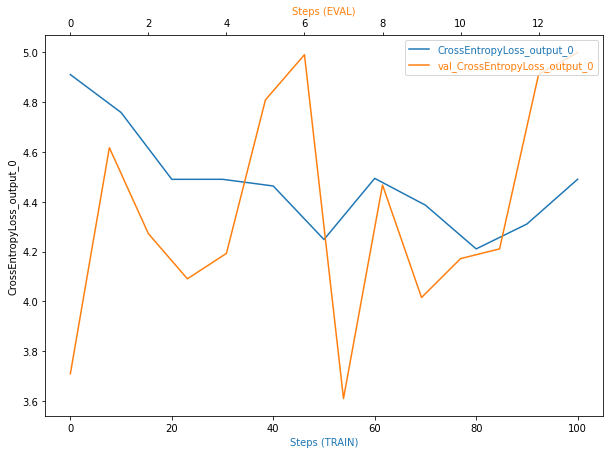

In [29]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**There is anomalous behaviour of not getting smooth output lines.
* **How would I go about fixing the anomalous behaviour?**
  * Making some adjustments in the pretrained model to use a different set of the fully connected layers network, ideally should help to smoothen out the graph.**
  * If I had more AWS credits, then would have changed the fc layers used in the model. Firstly would try by adding in one more fc layer on top of the existing two layers and check the results, and then if the results didn't improve much then would try by removing all the fc layers and keeping only one fc layer in the model and then rerun the tuning and training jobs and check the outputs

In [30]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/rule-output


In [31]:
! aws s3 ls {rule_output_path} --recursive

2021-12-15 12:17:26     381892 pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-15 12:17:25     231082 pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-15 12:17:19        191 pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-15 12:17:19      18745 pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-15 12:17:19        126 pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-15 12:17:19        129 pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-15 12:17:19       5408 pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-re

In [32]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-874422048278/pytorch-

In [33]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [34]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [35]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_repot.zip", "zip", "ProfilerReport")

'/root/DogBreed-Classification-using-AWS-Sagemaker/profiler_repot.zip.zip'

## Model Deploying

In [36]:
# TODO: Deploy your model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

------!

#### Note: The endpoint deployed directly by using the estimator object as done above was not working as expected and was throwing  Model Errors and Invocation timeout exceeded errors.
* Upon reading the docs, understood that for model deployment purposes we need to create a separate inference script, and override a few functions.
* Given the ideal and recommended approach was to create an endpoint inference script and use that to deploy the saved model from the previous training job, so went ahead and implemented that.
* References: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#deploy-pytorch-models

In [6]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-874422048278/pytorch-training-2021-12-15-12-06-44-446/output/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium") #Using ml.t2.medium to save costs


--------!

Test image no: 1
Below is the image that we will be testing:


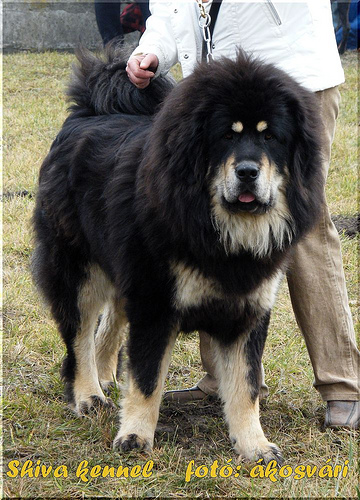

Expected dog breed category no : 129
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1649295538663864, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [76]
Test image no: 2
Below is the image that we will be testing:


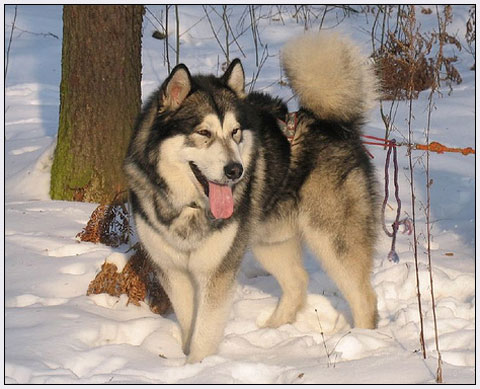

Expected dog breed category no : 5
Response: [[0.0, 0.0, 0.0, 0.0, 10.292489051818848, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2328356504440308, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.805440902709961, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.189020156860352, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [5]
Test image no: 3
Below is the image that we will be testing:


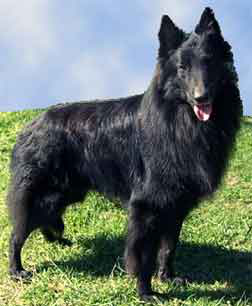

Expected dog breed category no : 21
Response: [[2.6692726612091064, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1089566946029663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004074650816619396, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016619451344013214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [1]


In [10]:
#Testing the deployed endpoint using some test images
#Solution 1: Using the Predictor object directly.
from PIL import Image
import io
import os
import numpy as np

test_dir = "./testImages"
test_images = [ "TestImg_Tibetan_mastiff.jpg", 'TestImg_Alaskan_malamute.jpg', 'TestImg_Belgian_sheepdog.jpg' ]
test_images_expected_output = [129, 5, 21 ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [59]:
# #using Pytorch attach to re create an estimator from the previously created training job, so we don't need to redo the training
# from sagemaker.pytorch import PyTorch
# training_job_name = 'pytorch-training-2021-12-15-12-06-44-446'
# pytorch_estimator = PyTorch.attach(training_job_name)


2021-12-15 12:21:30 Starting - Preparing the instances for training
2021-12-15 12:21:30 Downloading - Downloading input data
2021-12-15 12:21:30 Training - Training image download completed. Training in progress.
2021-12-15 12:21:30 Uploading - Uploading generated training model
2021-12-15 12:21:30 Completed - Training job completed


In [24]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-inference-2021-12-16-06-09-09-307


Test image no: 1
Below is the image that we will be testing:


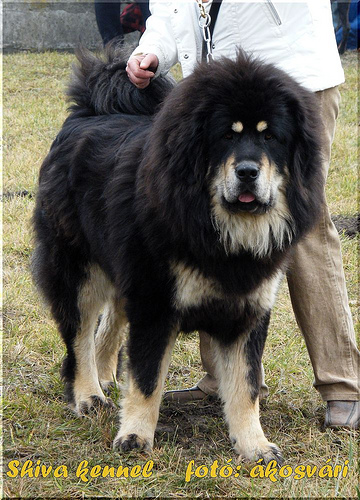

Expected dog breed category no : 129
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.16492955 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.     

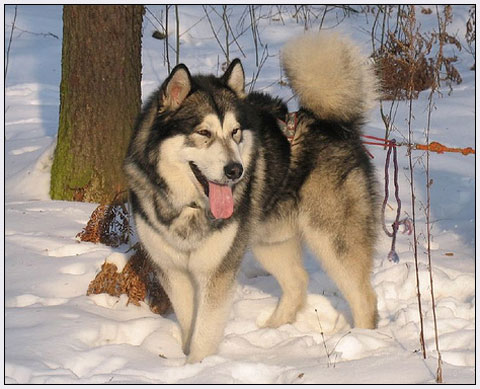

Expected dog breed category no : 5
Response: [[ 0.          0.          0.          0.         10.29248905  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.23283565
   0.          0.      

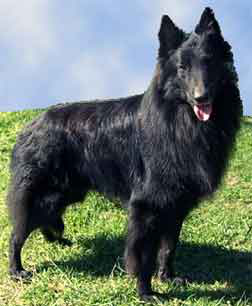

Expected dog breed category no : 21
Response: [[2.66927266 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.10895669 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00407465
  0.         0.         0.         0.         0.         0.
  0.         0.01661945 0.         0.         

In [26]:
# Solution 2: Using boto3
# Using the runtime boto3 client to test the deployed models endpoint
import os
import io
import boto3
import json
import base64
import PIL
# setting the  environment variables

ENDPOINT_NAME = endpoint_name
# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_dir = "./testImages"
test_images = [ "TestImg_Tibetan_mastiff.jpg", 'TestImg_Alaskan_malamute.jpg', 'TestImg_Belgian_sheepdog.jpg' ]
test_images_expected_output = [129, 5, 21 ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_dog_breed = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

**From the above test images we can see that from the 3 test images, model was able to correctly predict the breed of the second image.**

In [17]:
# best_hyperparameters = {'batch_size': '128', 'eps': '1.5009475698763981e-09', 'lr': '0.0029088382171354715', 'weight_decay': '0.08373215706456894'}
# print(best_hyperparameters)

{'batch_size': '128', 'eps': '1.5009475698763981e-09', 'lr': '0.0029088382171354715', 'weight_decay': '0.08373215706456894'}


In [63]:
# Uncomment and Using below to setup a predictor object if we have an active endpoint.
# predictor = Predictor( endpoint_name =  "pytorch-inference-2021-12-15-18-27-06-266" )

In [64]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2021-12-15-19-47-32-658
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2021-12-15-19-47-32-658
